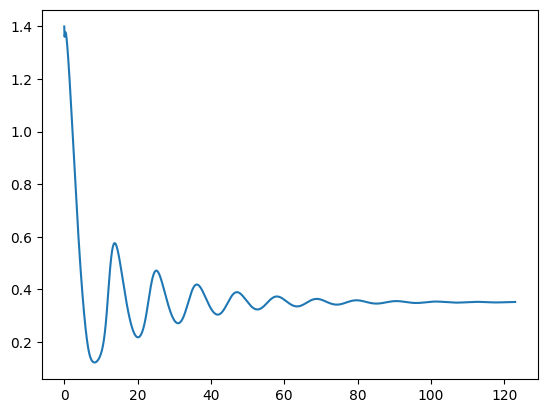

In [101]:
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import numpy as np

c1 = 0.185
c0 = 2
nu1 = 6
nu2 = 0.11
nu3 = 0.9
k3 = 0.1

a1 = 400
a2 = 0.2
a3 = 400
a4 = 0.2
a5 = 20

d1 = 0.13
d2 = 1.049
d3 = 943.4e-3
d4 = 144.5e-3
d5 = 82.34e-3

J1 = lambda C, CER, x110: c1 * (nu1 * x110 ** 3 + nu2) * (CER - C)
J2 = lambda C: nu3 * C**2 / (C**2 + k3**2)
CER = lambda C: (c0 - C) / c1
dCdt = lambda C, x110: J1(C, CER(C), x110) - J2(C)

def deyoungkeizerode(t, x, P):
    C, x000, x001, x010, x011, x100, x101, x110, x111 = x

    # print(x000 + x001 + x010 + x011 + x100 + x101 + x110 + x111)

    # Bottom face
    V1 = a4 * (C * x000 - d4 * x001) # x000 to x001
    V2 = a4 * (C * x010 - d4 * x011) # x010 to x011
    V3 = a5 * (C * x000 - d5 * x010) # x000 to x010
    V4 = a5 * (C * x001 - d5 * x011) # x001 to x011

    # Sides
    V5 = a1 * (P * x000 - d1 * x100) # x000 to x100
    V6 = a1 * (P * x010 - d1 * x110) # x010 to x110
    V7 = a3 * (P * x001 - d3 * x101) # x001 to x101
    V8 = a3 * (P * x011 - d3 * x111) # x011 to x111

    # Top face
    V9 = a2 * (C * x100 - d2 * x101) # x100 to x101
    V10 = a2 * (C * x110 - d2 * x111) # x110 to x111
    V11 = a5 * (C * x100 - d5 * x110) # x100 to x110
    V12 = a5 * (C * x101 - d5 * x111) # x101 to x111

    dx000dt = -V1 - V3 - V5
    dx001dt = V1 - V4 - V7
    dx010dt = V3 - V2 - V6
    dx011dt = V2 + V4 - V8

    dx100dt = V5 - V9 - V11
    dx101dt = V7 + V9 - V12
    dx110dt = V6 - V10 + V11
    dx111dt = V8 + V10 + V12

    # print(dx000dt + dx001dt + dx010dt + dx011dt + dx100dt + dx101dt + dx110dt + dx111dt)
    # print(sum([x000, x001, x010, x011, x100, x101, x110, x111]))

    return [dCdt(C, x110), dx000dt, dx001dt, dx010dt, dx011dt, dx100dt, dx101dt, dx110dt, dx111dt]

P = 0.7
t_span = [0, 500]
y0 = [1.4, 1, 0, 0, 0, 0, 0, 0, 0]
sol = solve_ivp(deyoungkeizerode, t_span, y0, args=(P,), max_step=0.1, rtol=1e-6, atol=1e-8)
plt.plot(sol.t, sol.y[0])
# print(', '.join(list(map(str, sol.y[:, -1]))))

[0.06180045 0.25477404 0.10894606 0.19122117 0.08176969 0.19598004
 0.01154824 0.14709321 0.00866755] [0.061797031050380445, 0.2547417356196255, 0.10901027415623153, 0.19118609958602178, 0.08181325801531866, 0.19595519063951666, 0.011555043174696704, 0.1470662375070038, 0.008672161301584628]


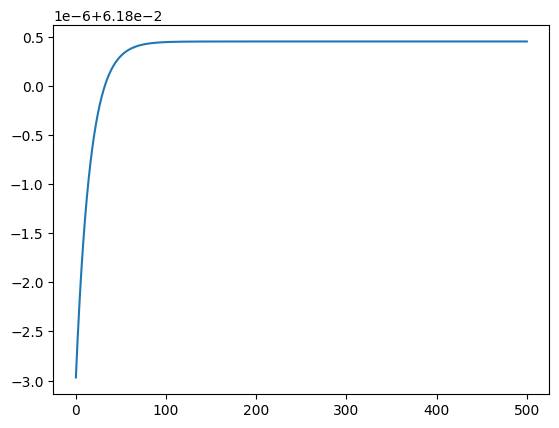

In [108]:
from scipy.optimize import fsolve

def find_steady_state(P, initial_guess=None, unsteady=False):
    if initial_guess is None:
        initial_guess = [0.061797031050380445, 0.2547417356196255, 0.10901027415623153, 0.19118609958602178, 0.08181325801531866, 0.19595519063951666, 0.011555043174696704, 0.1470662375070038, 0.008672161301584628]

    # func = lambda x: deyoungkeizerode(0, x, P)
    # C, x000, x001, x010, x011, x100, x101, x110, x111 = fsolve(func, initial_guess)
    # return C, x000, x001, x010, x011, x100, x101, x110, x111

    eps = 1e-4
    def steady_state_event(t, x, P):
        return np.linalg.norm(deyoungkeizerode(t, x, P)) - eps

    # Make it a terminal event
    steady_state_event.terminal = True
    # We want to trigger when the value crosses zero *downward* (norm(dxdt) < tol)
    steady_state_event.direction = -1

    t_span = [0, 500]
    if not unsteady:
        sol = solve_ivp(deyoungkeizerode, t_span, initial_guess, args=(P,), max_step=0.1, rtol=1e-6, atol=1e-8, events=steady_state_event)
    else:
        sol = solve_ivp(lambda t, x, P: np.negative(deyoungkeizerode(t, x, P)), t_span, initial_guess, args=(P,), max_step=0.1, rtol=1e-6, atol=1e-8, events=steady_state_event)

    plt.plot(sol.t, sol.y[0], label=f'{P}')
    return sol.y[:, -1]

# print(find_steady_state(0.1), [0.061797031050380445, 0.2547417356196255, 0.10901027415623153, 0.19118609958602178, 0.08181325801531866, 0.19595519063951666, 0.011555043174696704, 0.1470662375070038, 0.008672161301584628])
# print(sum([0.06186739406809979, 0.0337765780431877, 0.059291949202903746, 0.03237051082804615, 0.23795152096795955, 0.01790151402354118, 0.22804596357260917, 0.017156301410892524]))
# print(deyoungkeizerode(0, (0.07891231190364839, 0.06186739406809979, 0.0337765780431877, 0.059291949202903746, 0.03237051082804615, 0.23795152096795955, 0.01790151402354118, 0.22804596357260917, 0.017156301410892524), 0.5))

In [61]:
import sympy as sp

def jacobian(state, P):
    # print(state, P)
    C, x000, x001, x010, x011, x100, x101, x110, x111 = sp.symbols('C x000 x001 x010 x011 x100 x101 x110 x111')
    dCdt = c1 * (nu1 * x110 ** 3 + nu2) * ((c0 - C) / c1 - C)
    # Bottom face
    V1 = a4 * (C * x000 - d4 * x001) # x000 to x001
    V2 = a4 * (C * x010 - d4 * x011) # x010 to x011
    V3 = a5 * (C * x000 - d5 * x010) # x000 to x010
    V4 = a5 * (C * x001 - d5 * x011) # x001 to x011

    # Sides
    V5 = a1 * (P * x000 - d1 * x100) # x000 to x100
    V6 = a1 * (P * x010 - d1 * x110) # x010 to x110
    V7 = a3 * (P * x001 - d3 * x101) # x001 to x101
    V8 = a3 * (P * x011 - d3 * x111) # x011 to x111

    # Top face
    V9 = a2 * (C * x100 - d2 * x101) # x100 to x101
    V10 = a2 * (C * x110 - d2 * x111) # x110 to x111
    V11 = a5 * (C * x100 - d5 * x110) # x100 to x110
    V12 = a5 * (C * x101 - d5 * x111) # x101 to x111

    dx000dt = -V1 - V3 - V5
    dx001dt = V1 - V4 - V7
    dx010dt = V3 - V2 - V6
    dx011dt = V2 + V4 - V8

    dx100dt = V5 - V9 - V11
    dx101dt = V7 + V9 - V12
    dx110dt = V6 - V10 + V11
    dx111dt = V8 + V10 + V12

    F = sp.Matrix([dCdt, dx000dt, dx001dt, dx010dt, dx011dt, dx100dt, dx101dt, dx110dt, dx111dt])
    return np.array(F.jacobian([C, x000, x001, x010, x011, x100, x101, x110, x111]).subs(list(zip([C, x000, x001, x010, x011, x100, x101, x110, x111], state)))).astype(np.float64)

# print(jacobian((0.06180260051398122, 0.25479481687126343, 0.10895873964434254, 0.19124340879436114, 0.0817820434630336, 0.19599602237943928, 0.01154957890845187, 0.1471103215137941, 0.008668860959239176), 0.5))

0
[-4.17552476e+02 -4.20435285e+02 -9.20123552e+01 -9.48951642e+01
 -3.70860770e+00  6.48673335e-01 -3.44417330e-02 -2.94139808e+00
  1.31391001e-14] [[ 4.51266046e-07  5.27925541e-07  3.46859284e-03  3.96166277e-03
   8.56471727e-02  3.43441299e-01  1.52230026e-01  4.16870714e-03
  -1.96732288e-01]
 [ 8.93496671e-05 -7.89841677e-05  5.65728468e-01 -4.99799866e-01
   5.29669949e-01 -5.20281873e-01 -5.93509670e-01  2.02669717e-02
   7.41566905e-01]
 [-5.65412929e-01  4.99891604e-01  1.02829458e-04  7.10843705e-05
   2.24066638e-01 -1.72350789e-01  3.97350635e-01  7.02604279e-01
  -2.97054927e-02]
 [ 6.70518652e-05  7.89842782e-05  4.24261509e-01  4.99803621e-01
  -5.27577233e-01  4.76973778e-01  3.12613758e-02 -2.01380046e-02
  -5.21388032e-02]
 [-4.24371815e-01 -4.99891594e-01 -7.12602066e-05 -7.77010205e-05
  -2.27425561e-01  2.41588925e-01  5.02087099e-01 -7.02811133e-01
  -2.82596818e-01]
 [-3.34429069e-04  2.95683485e-04 -5.65374192e-01  5.00191745e-01
   4.07438459e-01 -4.00216783

KeyboardInterrupt: 

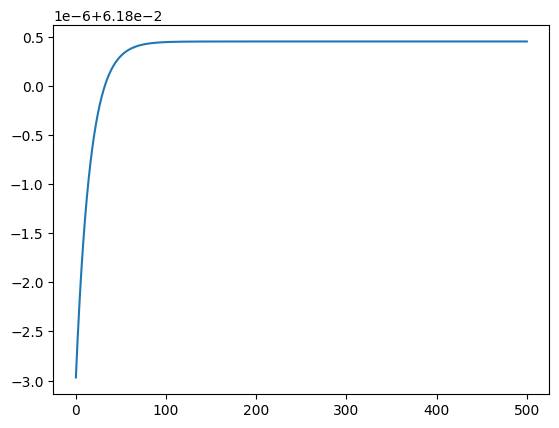

In [112]:
eps = 1e-10
n_points = 3
Ps = np.linspace(0.1, 0.7, n_points)
stabilities = np.zeros_like(Ps)
states = np.zeros((9, n_points))
for i, P in enumerate(Ps):
    print(i)
    if i == 0:
        guess = [0.061797031050380445, 0.2547417356196255, 0.10901027415623153, 0.19118609958602178, 0.08181325801531866, 0.19595519063951666, 0.011555043174696704, 0.1470662375070038, 0.008672161301584628]
    else:
        guess = states[:, i - 1]

    new_state = find_steady_state(P, guess)
    eigvals, eigvecs = np.linalg.eig(jacobian(new_state, P))
    print(eigvals, eigvecs)
    print(np.sum(eigvecs, axis=1))

    stable = max(eigvals) < eps
    print(stable)
    # if not stable:
    #     # Integrate back in time
    #     new_state = find_unstable_state(P, guess)
    #     eigvals = np.linalg.eigvals(jacobian(new_state, P))
    #     stable = max(eigvals) < 0

    states[:, i] = new_state
    stabilities[i] = stable

colors = ['blue' if stable else 'red' for stable in stabilities]
# plt.scatter(Ps, states[0], c=colors)
plt.legend()